In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), 'src/'))

import pandas as pd
pd.set_option('display.max_rows', 500)

from oce_ecomm_abv_calculation.datasets.default_datasets import uci_online_retail_ii_customer_order_view
from oce_ecomm_abv_calculation.sample_statistics.vanilla import VanillaSampleStatistics
from oce_ecomm_abv_calculation.sample_statistics.oneway_bootstrap import OnewayBootstrapStatistics
from datetime import datetime

from matplotlib import pyplot as plt
import numpy as np

In [2]:
uci_retail_co_df = uci_online_retail_ii_customer_order_view()

In [3]:
uci_retail_co_df

,RandomizationUnitId,AnalysisUnitId,EventReceivedTime,r_BasketValue,r_BasketSize
0,12346,499763,2010-03-02 13:08:00,27.05,5
1,12346,513774,2010-06-28 13:53:00,142.31,19
2,12346,541431,2011-01-18 10:01:00,77183.60,74215
3,12347,529924,2010-10-31 14:20:00,611.53,509
4,12347,537626,2010-12-07 14:57:00,1423.58,638
...,...,...,...,...,...
36589,18287,523290,2010-09-21 12:19:00,30.60,12
36590,18287,534346,2010-11-22 11:51:00,331.50,186
36591,18287,554065,2011-05-22 10:39:00,765.28,488
36592,18287,570715,2011-10-12 10:23:00,1001.32,990


In [2]:
vanilla = (
    VanillaSampleStatistics(
        dataset="uci_online_retail_ii_customer_order_view",
        response_col='r_BasketValue',
        start_time=datetime(2009, 12, 1),
        end_time=datetime(2012, 1, 1)
    )
)

In [3]:
vanilla.mean()

476.42959903262823

In [4]:
vanilla.standard_error()

7.183842985657441

In [5]:
oneway = (
    OnewayBootstrapStatistics(
        dataset="uci_online_retail_ii_customer_order_view",
        response_col='r_BasketValue',
        start_time=datetime(2009, 12, 1),
        end_time=datetime(2012, 1, 1)
    )
)

In [6]:
oneway.standard_error(num_bootstrap_means=500, verbose=True)

23.30019793460707

In [7]:
oneway.save_latest_result_as_pd_df()

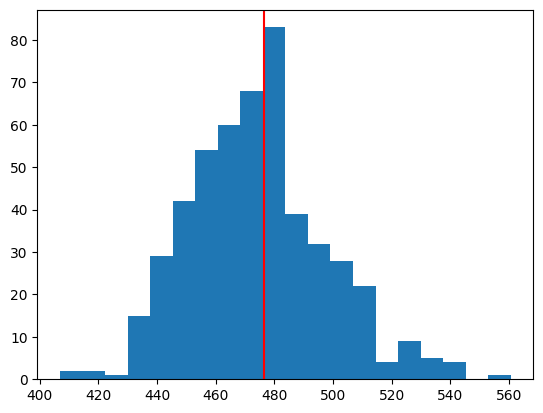

In [8]:
plt.hist(oneway.latest_means, bins=20)
plt.axvline(vanilla.mean(), c='red')

In [9]:
pd.read_parquet("data/expt_oneway_uci-online-retail-ii-customer-order-view_r-BasketValue_1667179189.parquet")

,dataset_name,response_col,start_time,end_time,num_bootstrap_means,bootstrap_mean,bootstrap_means,bootstrap_standard_error,count
0,uci_online_retail_ii_customer_order_view,r_BasketValue,2009-12-01,2012-01-01,500,477.220267,"[462.7314145728643, 465.1483613982705, 431.872...",25.185294,36594


In [17]:
min(oneway.dataset["EventReceivedTime"])

Timestamp('2009-12-01 07:45:00')

In [18]:
max(oneway.dataset["EventReceivedTime"])

Timestamp('2011-12-09 12:50:00')

In [22]:
test = (
    OnewayBootstrapStatistics(
        dataset=uci_retail_co_df,
        response_col='r_BasketValue',
        start_time=datetime(2009, 12, 1),
        end_time=datetime(2010, 1, 1)
    )
)

In [25]:
VanillaSampleStatistics(
    dataset=uci_retail_co_df,
    response_col='r_BasketValue',
    start_time=datetime(2009, 12, 1),
    end_time=datetime(2010, 1, 1)
).mean()

454.9540547762191

In [26]:
VanillaSampleStatistics(
    dataset=uci_retail_co_df,
    response_col='r_BasketValue',
    start_time=datetime(2009, 12, 1),
    end_time=datetime(2010, 1, 1)
).standard_error()

20.7153738710143

In [23]:
test.standard_error(num_bootstrap_means=500, verbose=True)

33.361322137953174

In [9]:
uci_retail_co_abv_oneway = (
    OnewayBootstrapStatistics(
        dataset="uci_online_retail_ii_customer_order_view",
        response_col='r_BasketValue',
        start_time=datetime(2009, 12, 1),
        end_time=datetime(2012, 1, 1)
    )
)

for i in range(1, 27):
    uci_retail_co_abv_oneway.standard_error(num_bootstrap_means=500, verbose=True)
    uci_retail_co_abv_oneway.save_latest_result_as_pd_df()
    print(f"Run {i} saved.                              ")

Run 1 saved.                              
Run 2 saved.                              
Run 3 saved.                              
Run 4 saved.                              
Run 5 saved.                              
Run 6 saved.                              
Run 7 saved.                              
Run 8 saved.                              
Run 9 saved.                              
Run 10 saved.                              
Run 11 saved.                              
Run 12 saved.                              
Run 13 saved.                              
Run 14 saved.                              
Run 15 saved.                              
Run 16 saved.                              
Run 17 saved.                              
Run 18 saved.                              
Run 19 saved.                              
Run 20 saved.                              
Run 21 saved.                              
Run 22 saved.                              
Run 23 saved.                            

In [10]:
uci_retail_co_abs_oneway = (
    OnewayBootstrapStatistics(
        dataset="uci_online_retail_ii_customer_order_view",
        response_col='r_BasketSize',
        start_time=datetime(2009, 12, 1),
        end_time=datetime(2012, 1, 1)
    )
)

for i in range(1, 31):
    uci_retail_co_abs_oneway.standard_error(num_bootstrap_means=500, verbose=True)
    uci_retail_co_abs_oneway.save_latest_result_as_pd_df()
    print(f"Run {i} saved.                              ")

Run 1 saved.                              
Run 2 saved.                              
Run 3 saved.                              
Run 4 saved.                              
Run 5 saved.                              
Run 6 saved.                              
Run 7 saved.                              
Run 8 saved.                              
Run 9 saved.                              
Run 10 saved.                              
Run 11 saved.                              
Run 12 saved.                              
Run 13 saved.                              
Run 14 saved.                              
Run 15 saved.                              
Run 16 saved.                              
Run 17 saved.                              
Run 18 saved.                              
Run 19 saved.                              
Run 20 saved.                              
Run 21 saved.                              
Run 22 saved.                              
Run 23 saved.                            

In [ ]:
uci_retail_coi_asp_oneway = (
    OnewayBootstrapStatistics(
        dataset="uci_online_retail_ii_customer_order_item_view",
        response_col='r_SellingPrice',
        start_time=datetime(2009, 12, 1),
        end_time=datetime(2012, 1, 1)
    )
)

for i in range(1, 31):
    uci_retail_coi_asp_oneway.standard_error(num_bootstrap_means=500, verbose=True)
    uci_retail_coi_asp_oneway.save_latest_result_as_pd_df()
    print(f"Run {i} saved.                              ")

Run 1 saved.                              
